In [1]:
import h2o
import operator
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np
from matplotlib import pyplot as plt
import warnings
from plot.ice import ice, ice_plot
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators import H2OGradientBoostingEstimator
warnings.filterwarnings("ignore")

# 1 Data Preparation

## 1.1 H2O Initialization

In [2]:
pct_memory=8
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

78


In [3]:
h2o.init(strict_version_check=False,max_mem_size=min_mem_size)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,6 mins 30 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.1
H2O cluster version age:,22 days
H2O cluster name:,H2O_from_python_mandy_fh8pqh
H2O cluster total nodes:,1
H2O cluster free memory:,84.4 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"locked, healthy"


## 1.2 Data Import & Parse

In [4]:
data_path = "data/AmazonReviews.Small.csv"

# Load data into H2O
reviews = h2o.import_file(data_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [5]:
reviews.shape

(55554, 10)

In [6]:
reviews.head(3)

ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text
B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1.34836e+09,"These are made in China (do not buy ANY pet food from China). Dogswell has been using propylene glycol to soften their treats (what are they thinkng?). Do not purchase or support this company in any way until they clean up their act. And for whatever reason Amazon doesn't allow returns of this item, so I had to toss mine out. Bad business all around on this one."
B0089SPEO2,A3JOYNYL458QHP,Less lemon and less zing,3,0,28582,coleridge,0,1.32391e+09,"Everything is ok, except it just isn't as good as it is in the bags. Just considerably more bland -- less lemon and less zing. Boring."
B001PMCDK2,A14TTMM0Z03Y2W,my cat goes crazy for these!,5,0,389965,Lindsay S. Bradford,0,1.3106e+09,"Best cat treat ever. There isn't anything comparable to the love my cat has for these treats, he snubs away any other kind now.I know he likes to manipulate me with his cattiness but these treats are my way of manipulating him to come sit on my lap and have some chill time. :)"


In [7]:
print(reviews.types)

{'ProductId': 'enum', 'UserId': 'enum', 'Summary': 'enum', 'Score': 'int', 'HelpfulnessDenominator': 'int', 'Id': 'int', 'ProfileName': 'enum', 'HelpfulnessNumerator': 'int', 'Time': 'int', 'Text': 'string'}


In [8]:
reviews['PositiveReview']=(reviews['Score']>=reviews['Score'].mean()[0]).ifelse('1','0')

In [9]:
reviews['PositiveReview'].table()

PositiveReview,Count
0,20106
1,35448


In [10]:
# Find the 80th quantile of time in the dataset
time_split = reviews["Time"].quantile(prob = [0.8])[1]
reviews["Train"] = (reviews["Time"] < time_split).ifelse("Yes", "No")

In [11]:
reviews['Train'].table()

Train,Count
No,11152
Yes,44402


In [12]:
train = reviews[reviews["Train"] == "Yes"]
test = reviews[reviews["Train"] == "No"]

## 1.3 Tokenize Words in Review

In [13]:
data_path = "data/stopwords.csv"
STOP_WORDS = pd.read_csv(data_path, header=0)

In [14]:
STOP_WORDS.head()

,STOP_WORD
0,all
1,just
2,being
3,over
4,both


In [15]:
STOP_WORDS = list(STOP_WORDS['STOP_WORD'])

In [16]:
def tokenize(sentences, stop_word = STOP_WORDS):
    tokenized = sentences.tokenize("\\W+")
    tokenized_lower = tokenized.tolower()
    tokenized_filtered = tokenized_lower[(tokenized_lower.nchar() >= 2) | (tokenized_lower.isna()),:]
    tokenized_words = tokenized_filtered[tokenized_filtered.grep("[0-9]",invert=True,output_logical=True),:]
    tokenized_words = tokenized_words[(tokenized_words.isna()) | (~ tokenized_words.isin(STOP_WORDS)),:]
    return tokenized_words

In [17]:
# Break reviews into sequence of words
words = tokenize(reviews["Text"])

In [18]:
words.head()

C1
made
china
buy
pet
food
china
dogswell
using
propylene
glycol


## 1.4 Word2Vec Model

In [19]:
# Train Word2Vec Model
from h2o.estimators.word2vec import H2OWord2vecEstimator


w2v_model = H2OWord2vecEstimator(vec_size = 100, model_id = "w2v.hex")
w2v_model.train(training_frame=words)

models_path='data'
h2o.save_model(w2v_model, path = models_path, force = True)

word2vec Model Build progress: |██████████████████████████████████████████| 100%


'/Users/mandy/Documents/Study/AI-Addin/data/w2v.hex'

In [20]:
# Sanity check - find synonyms for the word 'coffee'
w2v_model.find_synonyms("coffee", count = 5)

OrderedDict([('coffe', 0.7893892526626587),
             ('brew', 0.7611320614814758),
             ('coffees', 0.7606731653213501),
             ('espresso', 0.7463240623474121),
             ('expresso', 0.7416109442710876)])

In [21]:
# Sanity check - find synonyms for the word 'stale'
w2v_model.find_synonyms("stale", count = 5)

OrderedDict([('inedible', 0.665727436542511),
             ('rancid', 0.6598020195960999),
             ('tasteless', 0.6446768641471863),
             ('unedible', 0.6356924772262573),
             ('musty', 0.6313808560371399)])

In [22]:
# Calculate a vector for each review
review_vecs = w2v_model.transform(words, aggregate_method = "AVERAGE")
review_vecs

C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
-0.00673346,0.138516,0.00536622,-0.0492389,0.0159911,-0.215284,0.0215764,-0.212132,0.0141887,-0.0231987,-0.129713,0.00803689,0.0834671,0.0146434,-0.0215384,-0.081659,0.106969,0.0898843,0.0581625,-0.0343757,-0.0352144,-0.262466,0.0347936,-0.00573343,0.0828813,-0.0309528,0.0338674,-0.0829125,-0.0816757,-0.0518085,0.110838,0.194172,0.165707,-0.200362,-0.0276656,-0.208756,0.0473959,-0.126167,0.015811,-0.110748,0.141738,-0.222133,0.231704,-0.103909,-0.0319442,-0.017136,-0.0923194,-0.00225656,0.075541,-0.123125,0.0636505,-0.0464714,-0.173046,0.105927,0.0477022,-0.139712,-0.166252,0.222571,0.0313323,0.050401,-0.138379,0.19744,0.0250262,-0.0903883,-0.0564089,-0.0862252,-0.139518,-0.0818972,0.00411978,0.0381945,0.177508,-0.0307329,0.186346,0.0317712,-0.022985,-0.0681446,-3.16305e-05,0.119122,-0.0437245,0.0417158,0.00334229,0.134196,0.165307,-0.0476005,-0.0936798,-0.0959532,0.0178056,0.121738,0.0434943,0.0587462,-0.0329062,-0.0256889,-0.270224,0.0500385,0.0345928,-0.0452278,-0.0195481,-0.120581,0.0680059,-0.125823
-0.00926229,0.125367,-0.0781425,0.0554807,0.0646466,-0.046037,-0.220161,-0.199498,-0.0481974,0.0463867,-0.174281,-0.198949,0.0612451,0.0836036,0.117641,-0.106931,0.248301,-0.0611632,-0.149056,0.000799491,0.191638,-0.174702,-0.0879673,0.00862672,0.16769,-0.00759495,0.0708105,0.0203573,-0.0052044,-0.137299,0.0879493,0.241423,0.0740693,-0.104073,-0.0928337,0.121081,-0.0371581,0.0787184,-0.0569764,-0.102209,0.0520173,-0.0653757,0.207274,0.0102506,-0.0913367,-0.0545334,-0.0286182,0.023405,-0.00228351,-0.0028999,0.253373,0.0649332,0.0054025,0.125057,0.155357,0.0978915,0.0138259,0.133865,0.00265835,0.0532437,-0.122081,0.0992892,-0.090146,0.00919861,-0.0677997,0.00327377,0.0200766,-0.0560634,-0.0177063,0.0220796,-0.0135111,0.196974,0.126861,-0.0683619,0.138663,-0.119051,0.00730411,-0.0935161,0.0391973,-0.0166708,0.00291891,0.0484678,0.183502,0.114297,-0.0382902,-0.174614,-0.0914975,0.056517,-0.0644362,0.205295,-0.0429726,0.0230162,-0.159331,0.0590983,0.133523,0.00918488,-0.138713,0.0618043,-0.0444069,-0.0118911
0.0645578,0.0514826,-0.000335778,-0.022036,0.0974528,0.00202656,-0.159408,0.0136653,0.0635754,-0.0171529,-0.117997,-0.0795961,-0.0882959,0.102247,0.00623831,-0.135644,0.0864854,0.0656414,0.0452451,0.115625,0.112722,-0.269311,0.051456,-0.0243841,0.204821,0.126388,-0.0559646,0.00642317,-0.0741284,0.0357255,0.101446,0.101601,0.080844,-0.219866,-0.0567231,-0.168659,0.104485,-0.146287,-0.0108722,-0.0699547,0.0721822,-0.15392,0.266723,-0.0449351,-0.0101611,-0.081506,-0.0431078,0.0892107,-0.0236416,-0.0576266,0.133324,0.0460422,-0.0919176,0.131248,0.128033,-0.0170562,-0.0976307,0.14603,0.0395229,0.00438325,-0.0566625,0.185354,-0.0495215,-0.21975,-0.0694211,0.0723376,-0.085919,-0.242306,0.055132,-0.0106866,0.0324946,0.0126905,0.242577,0.0122209,0.111441,-0.035634,0.0938394,-0.0521078,-0.0312814,-0.0448192,-0.0244919,0.0310073,0.0898497,-0.0540329,-0.216453,-0.107421,-0.0224392,0.111498,-0.0564507,0.0880613,0.0595434,-0.0695728,-0.179166,0.0318767,0.0625963,0.098741,0.0756309,-0.0660988,0.0312488,-0.0622675
0.104856,0.113704,0.102924,-0.0212247,0.0905562,-0.0477681,-0.0666254,-0.00896991,0.0603932,-0.0150022,-0.0891916,0.0664903,-0.0067567,0.0138413,0.0042151,-0.0784333,0.222113,-0.0425604,0.0152847,0.0518078,0.0881551,-0.309256,-0.0460361,0.0429816,0.139552,0.0483533,-0.0870011,0.0358042,-0.0430379,-0.0238981,0.141971,0.176541,0.1564,-0.289592,-0.0335268,-0.051149,0.0847695,-0.188462,-0.114972,-0.0121263,0.0469859,-0.180821,0.18762,-0.0221241,-0.0209186,-0.00177908,-0.0604719,0.0865064,0.00608316,0.0088059,0.132177,-0.00741703,-0.0228988,0.165213,0.10

In [23]:
# Add aggregated word embeddings 
ext_reviews = reviews.cbind(review_vecs)

In [24]:
ext_reviews.head(3)

ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text,PositiveReview,Train,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1.34836e+09,"These are made in China (do not buy ANY pet food from China). Dogswell has been using propylene glycol to soften their treats (what are they thinkng?). Do not purchase or support this company in any way until they clean up their act. And for whatever reason Amazon doesn't allow returns of this item, so I had to toss mine out. Bad business all around on this one.",0,No,-0.00673346,0.138516,0.00536622,-0.0492389,0.0159911,-0.215284,0.0215764,-0.212132,0.0141887,-0.0231987,-0.129713,0.00803689,0.0834671,0.0146434,-0.0215384,-0.081659,0.106969,0.0898843,0.0581625,-0.0343757,-0.0352144,-0.262466,0.0347936,-0.00573343,0.0828813,-0.0309528,0.0338674,-0.0829125,-0.0816757,-0.0518085,0.110838,0.194172,0.165707,-0.200362,-0.0276656,-0.208756,0.0473959,-0.126167,0.015811,-0.110748,0.141738,-0.222133,0.231704,-0.103909,-0.0319442,-0.017136,-0.0923194,-0.00225656,0.075541,-0.123125,0.0636505,-0.0464714,-0.173046,0.105927,0.0477022,-0.139712,-0.166252,0.222571,0.0313323,0.050401,-0.138379,0.19744,0.0250262,-0.0903883,-0.0564089,-0.0862252,-0.139518,-0.0818972,0.00411978,0.0381945,0.177508,-0.0307329,0.186346,0.0317712,-0.022985,-0.0681446,-3.16305e-05,0.119122,-0.0437245,0.0417158,0.00334229,0.134196,0.165307,-0.0476005,-0.0936798,-0.0959532,0.0178056,0.121738,0.0434943,0.0587462,-0.0329062,-0.0256889,-0.270224,0.0500385,0.0345928,-0.0452278,-0.0195481,-0.120581,0.0680059,-0.125823
B0089SPEO2,A3JOYNYL458QHP,Less lemon and less zing,3,0,28582,coleridge,0,1.32391e+09,"Everything is ok, except it just isn't as good as it is in the bags. Just considerably more bland -- less lemon and less zing. Boring.",0,Yes,-0.00926229,0.125367,-0.0781425,0.0554807,0.0646466,-0.046037,-0.220161,-0.199498,-0.0481974,0.0463867,-0.174281,-0.198949,0.0612451,0.0836036,0.117641,-0.106931,0.248301,-0.0611632,-0.149056,0.000799491,0.191638,-0.174702,-0.0879673,0.00862672,0.16769,-0.00759495,0.0708105,0.0203573,-0.0052044,-0.137299,0.0879493,0.241423,0.0740693,-0.104073,-0.0928337,0.121081,-0.0371581,0.0787184,-0.0569764,-0.102209,0.0520173,-0.0653757,0.207274,0.0102506,-0.0913367,-0.0545334,-0.0286182,0.023405,-0.00228351,-0.0028999,0.253373,0.0649332,0.0054025,0.125057,0.155357,0.0978915,0.0138259,0.133865,0.00265835,0.0532437,-0.122081,0.0992892,-0.090146,0.00919861,-0.0677997,0.00327377,0.0200766,-0.0560634,-0.0177063,0.0220796,-0.0135111,0.196974,0.126861,-0.0683619,0.138663,-0.119051,0.00730411,-0.0935161,0.0391973,-0.0166708,0.00291891,0.0484678,0.183502,0.114297,-0.0382902,-0.174614,-0.0914975,0.056517,-0.0644362,0.205295,-0.0429726,0.0230162,-0.159331,0.0590983,0.133523,0.00918488,-0.138713,0.0618043,-0.0444069,-0.0118911
B001PMCDK2,A14TTMM0Z03Y2W,my cat goes crazy for these!,5,0,389965,Lindsay S. Bradford,0,1.3106e+09,"Best cat treat ever. There isn't anything comparable to the love my cat has for these treats, he snubs away any other kind now.I know he likes to manipulate me with his cattiness but these treats are my way of manipulating him to come sit on my lap and have some chill time. :)",1,Yes,0.0645578,0.0514826,-0.000335778,-0.022036,0.0974528,0.00202656,-0.159408,0.0136653,0.0635754,-0.0171529,-0.117997,-0.0795961,-0.0882959,0.102247,0.00623831,-0.135644,0.0864854,0.0656414,0.0452451,0.115625,0.112722,-0.269311,0.051456,-0.0243841,0.204821,0.126388,-0.0559646,0.00642317,-0.0741284,0.0357255,0.101446,0.101601,0.080844,-0.219866,-0.0567231,-0.168659,0.104485,-0.146287,-0.0

## 1.5 Add Summary Column

In [25]:
# Break summaries into sequence of word.
summary_words = tokenize(reviews['Summary'].ascharacter())

In [26]:
summary_vecs = w2v_model.transform(summary_words, aggregate_method='AVERAGE')
summary_vecs.names = ['summary_'+ s for s in summary_vecs.names]

ext_reviews_new = ext_reviews.cbind(summary_vecs)

In [27]:
ext_reviews_new.head(3)

ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text,PositiveReview,Train,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100,summary_C1,summary_C2,summary_C3,summary_C4,summary_C5,summary_C6,summary_C7,summary_C8,summary_C9,summary_C10,summary_C11,summary_C12,summary_C13,summary_C14,summary_C15,summary_C16,summary_C17,summary_C18,summary_C19,summary_C20,summary_C21,summary_C22,summary_C23,summary_C24,summary_C25,summary_C26,summary_C27,summary_C28,summary_C29,summary_C30,summary_C31,summary_C32,summary_C33,summary_C34,summary_C35,summary_C36,summary_C37,summary_C38,summary_C39,summary_C40,summary_C41,summary_C42,summary_C43,summary_C44,summary_C45,summary_C46,summary_C47,summary_C48,summary_C49,summary_C50,summary_C51,summary_C52,summary_C53,summary_C54,summary_C55,summary_C56,summary_C57,summary_C58,summary_C59,summary_C60,summary_C61,summary_C62,summary_C63,summary_C64,summary_C65,summary_C66,summary_C67,summary_C68,summary_C69,summary_C70,summary_C71,summary_C72,summary_C73,summary_C74,summary_C75,summary_C76,summary_C77,summary_C78,summary_C79,summary_C80,summary_C81,summary_C82,summary_C83,summary_C84,summary_C85,summary_C86,summary_C87,summary_C88
B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1.34836e+09,"These are made in China (do not buy ANY pet food from China). Dogswell has been using propylene glycol to soften their treats (what are they thinkng?). Do not purchase or support this company in any way until they clean up their act. And for whatever reason Amazon doesn't allow returns of this item, so I had to toss mine out. Bad business all around on this one.",0,No,-0.00673346,0.138516,0.00536622,-0.0492389,0.0159911,-0.215284,0.0215764,-0.212132,0.0141887,-0.0231987,-0.129713,0.00803689,0.0834671,0.0146434,-0.0215384,-0.081659,0.106969,0.0898843,0.0581625,-0.0343757,-0.0352144,-0.262466,0.0347936,-0.00573343,0.0828813,-0.0309528,0.0338674,-0.0829125,-0.0816757,-0.0518085,0.110838,0.194172,0.165707,-0.200362,-0.0276656,-0.208756,0.0473959,-0.126167,0.015811,-0.110748,0.141738,-0.222133,0.231704,-0.103909,-0.0319442,-0.017136,-0.0923194,-0.00225656,0.075541,-0.123125,0.0636505,-0.0464714,-0.173046,0.105927,0.0477022,-0.139712,-0.166252,0.222571,0.0313323,0.050401,-0.138379,0.19744,0.0250262,-0.0903883,-0.0564089,-0.0862252,-0.139518,-0.0818972,0.00411978,0.0381945,0.177508,-0.0307329,0.186346,0.0317712,-0.022985,-0.0681446,-3.16305e-05,0.119122,-0.0437245,0.0417158,0.00334229,0.134196,0.165307,-0.0476005,-0.0936798,-0.0959532,0.0178056,0.121738,0.0434943,0.0587462,-0.0329062,-0.0256889,-0.270224,0.0500385,0.0345928,-0.0452278,-0.0195481,-0.120581,0.0680059,-0.125823,0.0623427,0.0299695,-0.0279927,-0.165929,0.144624,-0.183349,-0.0554327,-0.350086,0.117181,0.350318,-0.165902,-0.0687774,0.151479,-0.166942,-0.0366812,-0.178134,0.155043,0.31651,0.189654,-0.0528387,0.0601109,-0.237728,0.112874,-0.076077,-0.0474025,0.0319118,0.085086,-0.223798,0.0161577,-0.274834,0.315239,-0.0212662,0.0154207,-0.0773692,-0.231121,-0.107672,0.0431322,-0.289768,-0.251439,0.0505564,0.18505,-0.26998,0.454105,0.0946791,-0.0327377,-0.028205,-0.00869425,0.148094,0.114202,-0.275058,0.308251,-0.172823,-0.0507494,0.185281,0.277649,-0.160101,0.276135,0.0188883,0.00487422,-0.01243,-0.152964,0.141052,-0.15345,0.132369,-0.119722,0.00967828,0.14854,-0.0676352,-0.136765,0.0249004,-0.0757042,-0.165452,0.109411,0.100748,0.00964899,-0.158191,-0.119262,0.0754573,0.0723991,0.106895,0.140846,-0.0249959,0.0833009,-0.0843863,-0.417924,0.0934732,0.0155327,0.309659
B0089SPEO2,A3JOYNYL458QHP,Less lemon and less zing,3,0,28582,coleridge,0,1.32391e+09,"Everything is ok, e

In [28]:
ext_train_new = ext_reviews_new[ext_reviews_new["Train"] == "Yes"]
ext_test_new = ext_reviews_new[ext_reviews_new["Train"] == "No"]

In [29]:
ext_test_simple = ext_test_new.drop([2, 6, 9])

In [30]:
predictors = ['ProductId', 'UserId', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time'] + summary_vecs.names + review_vecs.names 
response = 'PositiveReview'

# 2 Training Models

## 2.1 Linear Regression

### 2.1.1 Train & Fit Model

In [31]:
# Initialize
local_glm_plus = H2OGeneralizedLinearEstimator(family='binomial', model_id='glm_surrogate', lambda_search=True)
# train 
local_glm_plus.train(x=predictors, y=response, training_frame=ext_train_new)

glm Model Build progress: |███████████████████████████████████████████████| 100%


### 2.1.2 Interpretability

#### Variable Importance

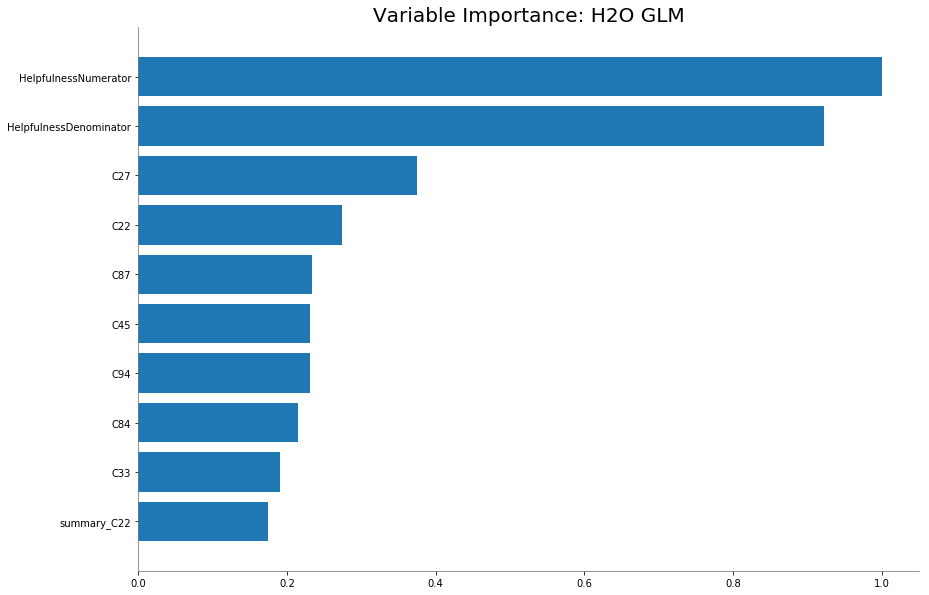

In [32]:
local_glm_plus.varimp_plot()

#### Partial Dependence Plot (PDP)

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


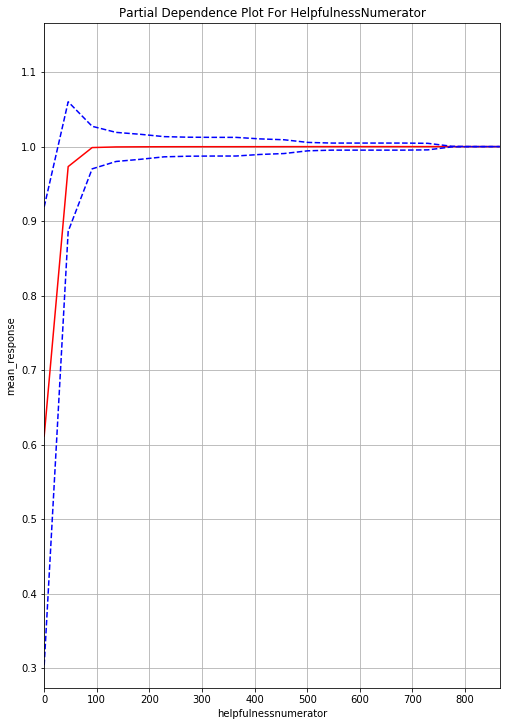

In [33]:
pdp_local_linear_plus = local_glm_plus.partial_plot(data = ext_train_new, cols = ["HelpfulnessNumerator"])

#### Individual Conditional Expectation (ICE)

In [36]:
HelpfulnessNumerator_ice_df = ice(data=ext_test_simple, column='HelpfulnessNumerator', model=local_glm_plus)

Parse progress: |█████████████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


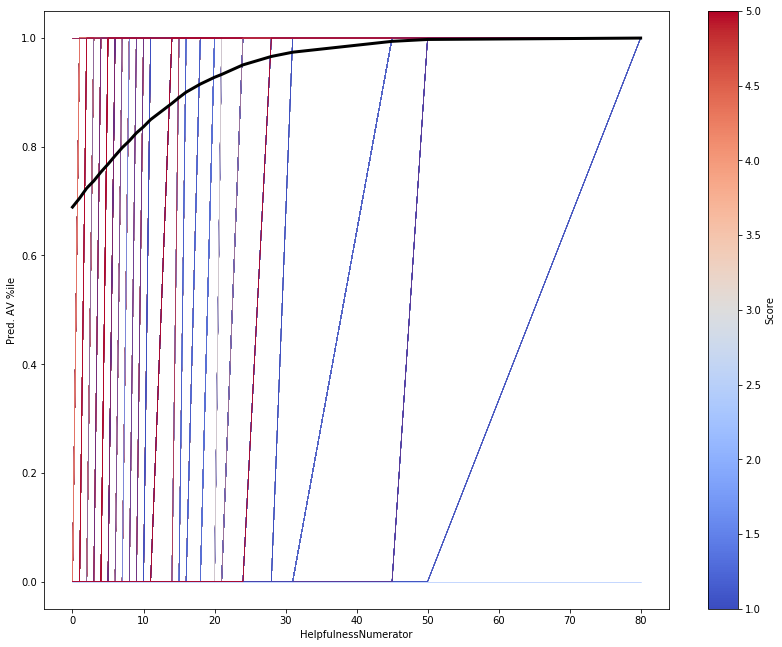

In [37]:
ice_plot(HelpfulnessNumerator_ice_df, linewidth=0.5, color_by='Score', cmap='coolwarm',
        plot_pdp=True, pdp_kwargs={'c': 'k', 'linewidth': 3})
vals = HelpfulnessNumerator_ice_df.columns.get_level_values('Score').values
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vals.min(), vmax=vals.max()))
sm._A = []
plt.colorbar(sm, label='Score')
plt.ylabel('Pred. AV %ile')
plt.xlabel('HelpfulnessNumerator');

### 2.1.3 Matrix

In [38]:
print('\nLocal GLM Coefficients:')
for c_name, c_val in sorted(local_glm_plus.coef().items(), key=operator.itemgetter(1)):
    if c_val != 0.0:
        print('%s %s' % (str(c_name + ':').ljust(25), c_val))


Local GLM Coefficients:
C22:                      -4.155718056036148
C94:                      -3.822656045453817
C84:                      -3.554480200551809
C45:                      -3.484780414402958
C87:                      -3.2659876391740936
C33:                      -2.8022493523158962
C38:                      -2.0773759422828246
C21:                      -2.007971609696023
C98:                      -1.984763353305128
C6:                       -1.665357154546245
C95:                      -1.6477907545644048
C65:                      -1.554108975266539
C49:                      -1.4925166631376823
C16:                      -1.3363694980537446
C19:                      -1.2090762815457876
summary_C22:              -1.16746623542772
C59:                      -1.10997379784825
C69:                      -1.054647994249894
C73:                      -1.0234681768601919
C31:                      -1.012770129647702
C60:                      -1.0091230403460485
C32:                   

In [39]:
local_glm_plus.r2(train=True, valid=True)

{'train': 0.42846638133703263, 'valid': None}

In [40]:
local_glm_plus.auc()

0.8749329925231295

In [41]:
local_glm_plus.confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45739478619057256: 


,0,1,Error,Rate
0,9981.0,5913.0,0.372,(5913.0/15894.0)
1,2226.0,26282.0,0.0781,(2226.0/28508.0)
Total,12207.0,32195.0,0.1833,(8139.0/44402.0)


## 2.2 Logistic Regression

### 2.2.1 Train & Fit Model

In [31]:
glm_logistic_plus_summary = H2OGeneralizedLinearEstimator(family = "binomial")
glm_logistic_plus_summary.train(x=predictors, 
                               y= response, 
                               training_frame = ext_train_new, 
                               validation_frame = ext_test_new, 
                               model_id="glm_logistic")

glm Model Build progress: |███████████████████████████████████████████████| 100%


### 2.2.2 Interpretability

#### Variable Importance

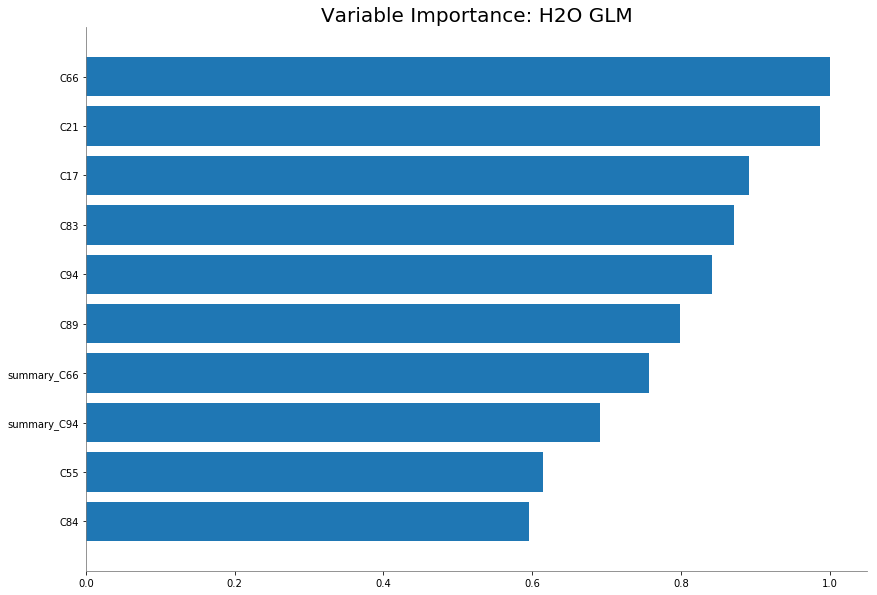

In [32]:
glm_logistic_plus_summary.varimp_plot()

#### Partial Dependence Plot (PDP)

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


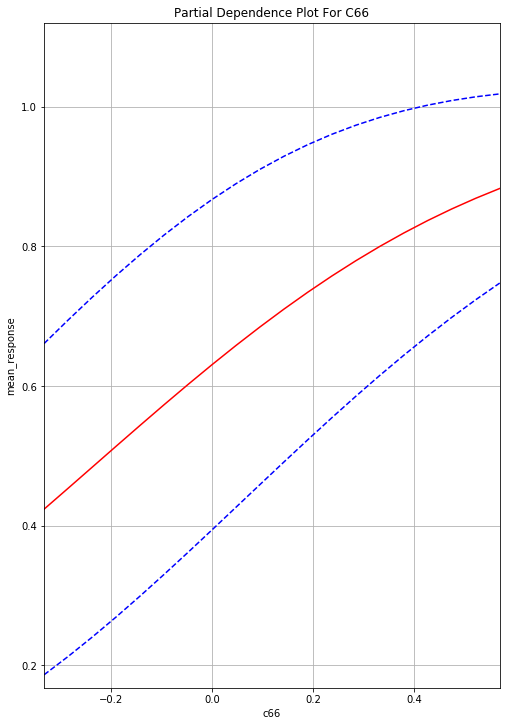

In [33]:
pdp_word_vecs = glm_logistic_plus_summary.partial_plot(data = ext_train_new, cols = ["C66"])

#### Individual Conditional Expectation (ICE)

In [ ]:
C66_ice_df = ice(data=ext_test_simple, column='C66', model=glm_logistic_plus_summary)

In [ ]:
ice_plot(C66_ice_df, linewidth=0.5, color_by='Score', cmap='coolwarm',
        plot_pdp=True, pdp_kwargs={'c': 'k', 'linewidth': 3})
vals = C66_ice_df.columns.get_level_values('Score').values
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vals.min(), vmax=vals.max()))
sm._A = []
plt.colorbar(sm, label='Score')
plt.ylabel('Pred. AV %ile')
plt.xlabel('C66');

### 2.2.3 Matrix

In [68]:
print("With Summary and Review Embeddings AUC: " + str(round(glm_logistic_plus_summary.auc(valid = True), 3)))

With Summary and Review Embeddings AUC: 0.857


In [69]:
glm_logistic_plus_summary.confusion_matrix(valid = True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46869425484942073: 


,0,1,Error,Rate
0,2452.0,1760.0,0.4179,(1760.0/4212.0)
1,501.0,6439.0,0.0722,(501.0/6940.0)
Total,2953.0,8199.0,0.2027,(2261.0/11152.0)


In [70]:
glm_logistic_plus_summary.confusion_matrix(valid = True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46869425484942073: 


,0,1,Error,Rate
0,2452.0,1760.0,0.4179,(1760.0/4212.0)
1,501.0,6439.0,0.0722,(501.0/6940.0)
Total,2953.0,8199.0,0.2027,(2261.0/11152.0)


## 2.3 Decision Tree

In [71]:
from h2o.estimators.random_forest import H2ORandomForestEstimator # for single tree
# in-notebook display
from IPython.display import Image
from IPython.display import display
%matplotlib inline

### 2.3.1 Train & Fit Model

In [72]:
predictors = ['ProductId', 'UserId', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time'] + review_vecs.names + summary_vecs.names
response = 'PositiveReview'

In [73]:
# initialize single tree surrogate model
model_id = 'dt_surrogate_mojo'

# train single tree surrogate model
surrogate = H2OGradientBoostingEstimator(ntrees=1,
                                         sample_rate=1,
                                         col_sample_rate=1,
                                         max_depth=3,
                                         seed=12345,
                                         model_id=model_id)

_ = surrogate.train(x=predictors, y=response, training_frame=ext_train_new)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


### 2.3.2 Interpretability

#### Variable Importance

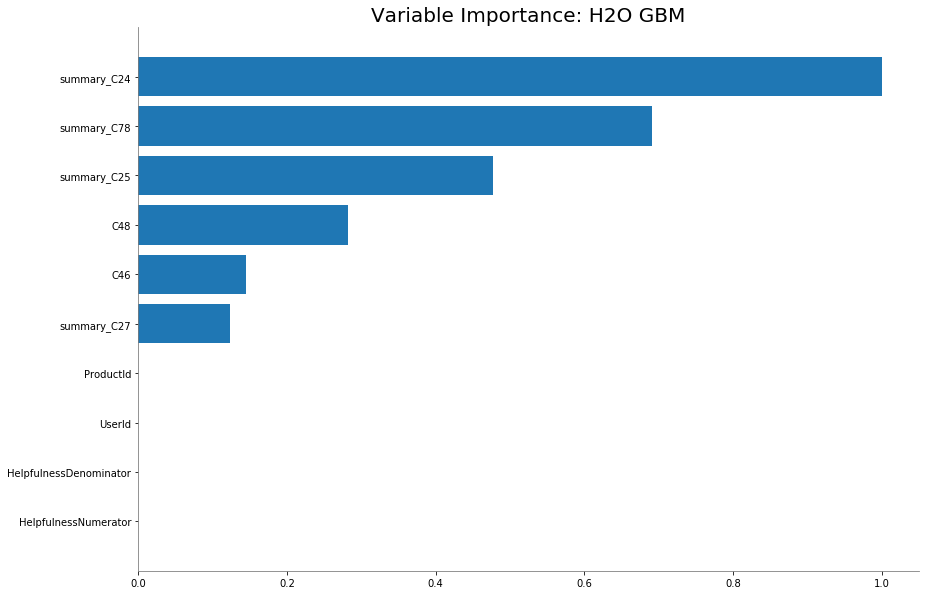

In [74]:
surrogate.varimp_plot()

#### Partial Dependence Plot (PDP)

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


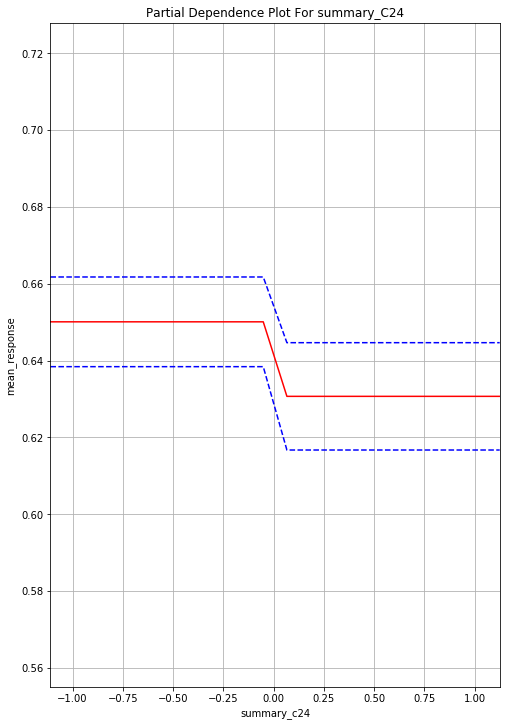

In [75]:
pdp_word_vecs = surrogate.partial_plot(data = ext_train_new, cols = ["summary_C24"])

#### Individual Conditional Expectation (ICE)

In [ ]:
summary_C24_ice_df = ice(data=ext_test_simple, column='summary_C24', model=surrogate)

In [ ]:
ice_plot(summary_C24_ice_df, linewidth=0.5, color_by='Score', cmap='coolwarm',
        plot_pdp=True, pdp_kwargs={'c': 'k', 'linewidth': 3})
vals = summary_C24_ice_df.columns.get_level_values('Score').values
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vals.min(), vmax=vals.max()))
sm._A = []
plt.colorbar(sm, label='Score')
plt.ylabel('Pred. AV %ile')
plt.xlabel('summary_C24');

### 2.3.3 Matrix

In [76]:
print(surrogate)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  dt_surrogate_mojo


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.22490468188680712
RMSE: 0.4742411642685682
LogLoss: 0.6415846447228967
Mean Per-Class Error: 0.35615213187394557
AUC: 0.692578222817862
pr_auc: 0.42284625175470336
Gini: 0.38515644563572393
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6287949244602625: 


,0,1,Error,Rate
0,4338.0,11556.0,0.7271,(11556.0/15894.0)
1,2322.0,26186.0,0.0815,(2322.0/28508.0)
Total,6660.0,37742.0,0.3126,(13878.0/44402.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.6287949,0.7905208,5.0
max f2,0.6115796,0.8996806,7.0
max f0point5,0.6419479,0.7451607,3.0
max accuracy,0.6287949,0.6874465,5.0
max precision,0.6589095,0.8125619,0.0
max recall,0.6115796,1.0,7.0
max specificity,0.6589095,0.8212533,0.0
max absolute_mcc,0.6419479,0.2880008,3.0
max min_per_class_accuracy,0.6446020,0.6281616,2.0
max mean_per_class_accuracy,0.6446020,0.6438479,2.0


Gains/Lift Table: Avg response rate: 64.20 %, avg score: 64.19 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.3413585,0.6589095,1.2655876,1.2655876,0.8125619,0.6589095,0.8125619,0.6589095,0.4320191,0.4320191,26.5587603,26.5587603
,2,0.5565515,0.6446020,1.0572606,1.1850371,0.6788069,0.6457080,0.7608449,0.6538051,0.2275151,0.6595342,5.7260569,18.5037068
,3,0.6457817,0.6419479,0.9985160,1.1592647,0.6410904,0.6419479,0.7442980,0.6521667,0.0890978,0.7486320,-0.1484001,15.9264714
,4,0.7469709,0.6336163,0.8694145,1.1199999,0.5582016,0.6336163,0.7190883,0.6496538,0.0879753,0.8366073,-13.0585466,11.9999877
,5,0.8500068,0.6287949,0.7952754,1.0806375,0.5106011,0.6287949,0.6938159,0.6471253,0.0819419,0.9185492,-20.4724648,8.0637503
,6,1.0,0.6115796,0.5430299,1.0,0.3486486,0.6122017,0.6420432,0.6418870,0.0814508,1.0,-45.6970068,0.0



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
,2019-04-23 19:11:28,0.005 sec,0.0,0.4793994,0.6522336,0.5,0.0,1.0,0.3579568
,2019-04-23 19:11:28,0.107 sec,1.0,0.4742412,0.6415846,0.6925782,0.4228463,1.2655876,0.3125535


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
summary_C24,420.7445679,1.0,0.3677554
summary_C78,290.7519531,0.6910415,0.2541342
summary_C25,200.9385681,0.4775785,0.1756321
C48,118.4606781,0.2815501,0.1035416
C46,61.1193810,0.1452648,0.0534219
---,---,---,---
summary_C96,0.0,0.0,0.0
summary_C97,0.0,0.0,0.0
summary_C98,0.0,0.0,0.0
summary_C99,0.0,0.0,0.0



See the whole table with table.as_data_frame()



## 2.4 Gradient Boosting

### 2.4.1 Train & Fit Model

In [77]:
gbm = H2OGradientBoostingEstimator(stopping_metric = "AUC",
                                           stopping_tolerance = 0.001,
                                           stopping_rounds = 5, 
                                           score_tree_interval = 10, 
                                           model_id = 'gbm.hex')
gbm.train(x = predictors, 
                   y = response,
                  training_frame = ext_train_new,
                  validation_frame = ext_test_new)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


### 2.4.2 Interpretability

#### Variable Importance

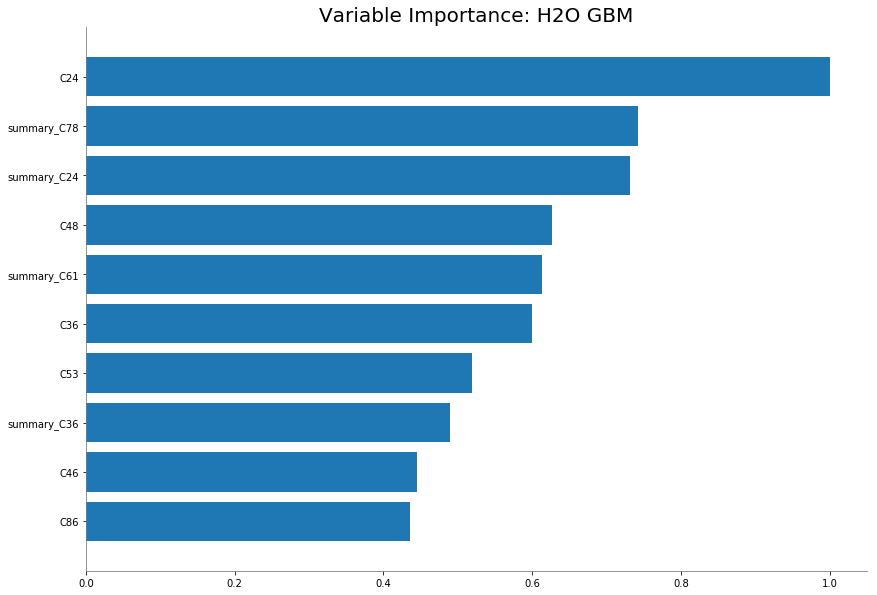

In [78]:
gbm.varimp_plot()

#### Partial Dependence Plot (PDP)

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


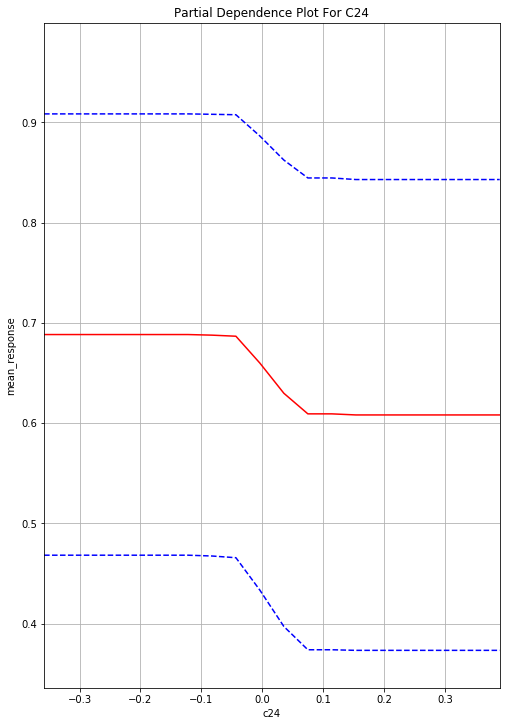

In [79]:
pdp_helpfulness = gbm.partial_plot(ext_train_new, cols = ['C24'])

#### Individual Conditional Expectation (ICE)

In [66]:
C24_ice_df = ice(data=ext_test_simple, column='C24', model=gbm)

NameError: name 'ext_test_s' is not defined

In [ ]:
ice_plot(C24_ice_df, linewidth=0.5, color_by='Score', cmap='coolwarm',
        plot_pdp=True, pdp_kwargs={'c': 'k', 'linewidth': 3})
vals = C24_ice_df.columns.get_level_values('Score').values
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vals.min(), vmax=vals.max()))
sm._A = []
plt.colorbar(sm, label='Score')
plt.ylabel('Pred. AV %ile')
plt.xlabel('C24');

### 2.4.3 Matrix

In [80]:
print("AUC on validation data: " + str(round(gbm.auc(valid = True), 3)))

AUC on validation data: 0.851


In [81]:
gbm.confusion_matrix(valid=True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5160766138956321: 


,0,1,Error,Rate
0,2541.0,1671.0,0.3967,(1671.0/4212.0)
1,641.0,6299.0,0.0924,(641.0/6940.0)
Total,3182.0,7970.0,0.2073,(2312.0/11152.0)


In [82]:
gbm.r2(train=True, valid=True)

{'train': 0.439767865367519, 'valid': 0.3583848043975397}

In [1]:
# h2o.cluster().shutdown()

NameError: name 'h2o' is not defined